# Análisis de la co-expresión de Hopx en células Sox2 positivas en la zona granular del Hipocampo

Vamos a importar las librerias necesarias para ejecutar el script

In [1]:
import os
import time
from skimage.io import imread
from skimage import filters, measure, morphology
import pandas as pd 
import numpy as np
import pyclesperanto_prototype as cle
from apoc import ObjectSegmenter
import tifffile as tf
from ipywidgets import interact

El código utiliza la GPU del ordenador para realizar diferentes operaciones, por lo que vamos a ver que GPU's están disponibles para trabajar en le ordenador

In [2]:
gpu_devices = cle.available_device_names(dev_type="gpu")
print("Available GPU OpenCL devices:" + str(gpu_devices))

Available GPU OpenCL devices:['Intel(R) Iris(R) Xe Graphics', 'NVIDIA GeForce RTX 3080 Ti Laptop GPU', 'Microsoft Basic Render Driver', 'Intel(R) Iris(R) Xe Graphics', 'NVIDIA GeForce RTX 3080 Ti Laptop GPU']


In [3]:
cle.select_device("RTX") #Select desired GPU 'NVIDIA', 'Intel', 'RTX', etc.
print("Using OpenCL device " + cle.get_device().name)

Using OpenCL device NVIDIA GeForce RTX 3080 Ti Laptop GPU


Para procesar imágenes en serie es necesario fijar nuestro folder de trabajo, cada uno de los canales debe estar en una carpeta separada y cada imagen debe tener el mismo nombre

In [4]:
# Definir el folder con imágenes a analizar y donde vamos a guardar los resultados
dapi_dir = r"F:\CI2A\Image Analysis\Aixa\Pilar\dapi"
Hopx_dir = r"F:\CI2A\Image Analysis\Aixa\Pilar\Hopx"
Sox2_dir = r"F:\CI2A\Image Analysis\Aixa\Pilar\Sox2"
labels_dir = r"F:\CI2A\Image Analysis\Aixa\Pilar\labels" #ML generated segmentation, you can erase this folder after
granular_dir = r"F:\CI2A\Image Analysis\Aixa\Pilar\granular" #Biggest label selection for Granular zone segmentation
tables_dir = r"F:\CI2A\Image Analysis\Aixa\Pilar\tables" #Tables with granular eegion volume and
mask_Hopx_dir = r"F:\CI2A\Image Analysis\Aixa\Pilar\mHopx" #Segmented Hopx signal in the granular zone
mask_Sox2_dir = r"F:\CI2A\Image Analysis\Aixa\Pilar\mSox2" #Segmented Sox2 signal in the granular zone
lbsox_dir = r"F:\CI2A\Image Analysis\Aixa\Pilar\Sox2lb" #Sox2 segmented cell on the granular zone

Vamos a definir una función para generar las etiquetas para extraer las zona basadas en el pixel classifier que hemos generado en el paso anterior

In [5]:
segmenter = ObjectSegmenter(opencl_filename='F:/CI2A/Image Analysis/Aixa/Analysis_Pipelines/ObjectSegmenter.cl')

Ahora vamos a procesar cada imagen con el pixel classifier

In [6]:
for filename in os.listdir(dapi_dir):
    start_time = time.time()
    image1 = imread(dapi_dir +'/'+ filename)
    labels = segmenter.predict(image=image1)
    tf.imwrite(labels_dir +'/'+ filename, labels)
    print ('Processing '+ filename + ' took '+ str(time.time() - start_time) + " s.")

Processing Reunion Edwin 160223.lif - M155 40x s1 Hopx Sox2.tif took 4.205355882644653 s.
Processing Reunion Edwin 160223.lif - M155 40x s2 Hopx Sox2.tif took 4.860569715499878 s.
Processing Reunion Edwin 160223.lif - M155 40x s3 Hopx Sox2.tif took 3.7841708660125732 s.
Processing Reunion Edwin 160223.lif - M156 40x s1 Hopx Sox2.tif took 4.591080188751221 s.
Processing Reunion Edwin 160223.lif - M156 40x s2 Hopx Sox2.tif took 5.77959132194519 s.
Processing Reunion Edwin 160223.lif - M156 40x s3 Hopx Sox2.tif took 4.830617427825928 s.


Es hora de analizar las características de cada una de las segmentaciones que hemos generado y quedarnos solamente con la región más grande que en este caso debe corresponder a la zona granular.

In [7]:
for filename1 in os.listdir(labels_dir):
    
    start_time1 = time.time()
    
    label1 = imread(labels_dir +'/'+ filename1).astype(np.uint16)
    
    # Labels poperties measurements
    table = measure.regionprops(label1)
    
    # Find biggest label
    size = max([i.area for i in table])
    
    # Keep biggest label and save it in a new file
    biggest = morphology.remove_small_objects(label1, min_size=size-1)
    bina = cle.threshold_otsu(biggest) #Just to re-assign label value to 1
    tf.imwrite(
        granular_dir +'/'+ filename1,
        bina,
        imagej=True,
        resolution=(1./0.3787879, 1./0.3787879),
        metadata={
            'spacing': 1.9998568,
            'unit': 'micron',
            'axes': 'ZYX'})
    
    print ('processing '+ filename1 + ' took '+ str(time.time() - start_time1) + ' s.')

processing Reunion Edwin 160223.lif - M155 40x s1 Hopx Sox2.tif took 0.747600793838501 s.
processing Reunion Edwin 160223.lif - M155 40x s2 Hopx Sox2.tif took 0.6282100677490234 s.
processing Reunion Edwin 160223.lif - M155 40x s3 Hopx Sox2.tif took 0.4554128646850586 s.
processing Reunion Edwin 160223.lif - M156 40x s1 Hopx Sox2.tif took 0.7720732688903809 s.
processing Reunion Edwin 160223.lif - M156 40x s2 Hopx Sox2.tif took 0.7734658718109131 s.
processing Reunion Edwin 160223.lif - M156 40x s3 Hopx Sox2.tif took 1.0242133140563965 s.


Ahora podemos extraer la información del tamaño de la zona granular

In [8]:
for mask in os.listdir(granular_dir):
       
    start_time2 = time.time()
    
    grn = imread(granular_dir+'/'+mask)
    short_name = os.path.splitext(mask)
    
    #Get Granular Zone Volume, don't worry that is the area name, area for 2D images, volume for 3D, is a maching cubes calculation
    properties = ['label', 'area']
    
    table = measure.regionprops(grn, spacing = [1.9998568, 0.3787879, 0.3787879])
    props = pd.DataFrame(measure.regionprops_table(grn, properties=properties, spacing = [1.9998568, 0.3787879, 0.3787879])).set_index('label')
    props.to_csv(tables_dir+'/'+str(short_name[0])+'.csv')

    print(f'Granular region in label {table[0].label} '+ mask + f' has volume {table[0].area} µm3')           

Granular region in label 1 Reunion Edwin 160223.lif - M155 40x s1 Hopx Sox2.tif has volume 1909632.7581446916 µm3
Granular region in label 1 Reunion Edwin 160223.lif - M155 40x s2 Hopx Sox2.tif has volume 1677114.3724265555 µm3
Granular region in label 1 Reunion Edwin 160223.lif - M155 40x s3 Hopx Sox2.tif has volume 1242356.3706100406 µm3
Granular region in label 1 Reunion Edwin 160223.lif - M156 40x s1 Hopx Sox2.tif has volume 2016928.8062238314 µm3
Granular region in label 1 Reunion Edwin 160223.lif - M156 40x s2 Hopx Sox2.tif has volume 1860524.9857250853 µm3
Granular region in label 1 Reunion Edwin 160223.lif - M156 40x s3 Hopx Sox2.tif has volume 2245851.8337419964 µm3


Ahora vamos a extraer los pixeles originales de las áreas que hemos definido como zona granular para los marcajes de Sox2 Y Hopx, para ello vamos a definir una función que nos genere los canales segmentados

In [9]:
def extract_raw_masked_pixels(raw, mask):
    output_data = np.empty_like(raw)
    output_data = np.where(mask==1, raw, 0)
    output_data = output_data.astype(raw.dtype)
    return output_data
    pass       

Ahora podemos procesar los archivos que contienen el marcaje de Hopx

In [10]:
for img_name in os.listdir(Hopx_dir):
    
    start_time3 = time.time()
        
    img1_path = os.path.join(Hopx_dir, img_name)
    
    if img_name in os.listdir(granular_dir):
               
        img2_path = os.path.join(granular_dir, img_name)
        
        img1 = imread(img1_path)
        img2 = imread(img2_path)
        
        result = extract_raw_masked_pixels(img1, img2)
        
        tf.imwrite(mask_Hopx_dir+'/'+img_name, result)
        
        print ('Generating Hopx mask of '+ img_name + ' took '+ str(time.time() - start_time3) + ' s.')

Generating Hopx mask of Reunion Edwin 160223.lif - M155 40x s1 Hopx Sox2.tif took 0.25430750846862793 s.
Generating Hopx mask of Reunion Edwin 160223.lif - M155 40x s2 Hopx Sox2.tif took 0.21921133995056152 s.
Generating Hopx mask of Reunion Edwin 160223.lif - M155 40x s3 Hopx Sox2.tif took 0.16323041915893555 s.
Generating Hopx mask of Reunion Edwin 160223.lif - M156 40x s1 Hopx Sox2.tif took 0.30541014671325684 s.
Generating Hopx mask of Reunion Edwin 160223.lif - M156 40x s2 Hopx Sox2.tif took 0.25832128524780273 s.
Generating Hopx mask of Reunion Edwin 160223.lif - M156 40x s3 Hopx Sox2.tif took 0.22112154960632324 s.


Ahora podemos procesar los archivos que contienen el marcaje de Sox2

In [11]:
for img_name in os.listdir(Sox2_dir):
    
    start_time4 = time.time()
    
    img1_path = os.path.join(Sox2_dir, img_name)
    
    if img_name in os.listdir(granular_dir):
               
        img2_path = os.path.join(granular_dir, img_name)
        
        img1 = imread(img1_path)
        img2 = imread(img2_path)
        
        result = extract_raw_masked_pixels(img1, img2)
        
        tf.imwrite(mask_Sox2_dir+'/'+img_name, result)
        
        print ('Generating Sox2 mask of '+ img_name + ' took '+ str(time.time() - start_time3) + ' s.')

Generating Sox2 mask of Reunion Edwin 160223.lif - M155 40x s1 Hopx Sox2.tif took 0.4927699565887451 s.
Generating Sox2 mask of Reunion Edwin 160223.lif - M155 40x s2 Hopx Sox2.tif took 0.720858097076416 s.
Generating Sox2 mask of Reunion Edwin 160223.lif - M155 40x s3 Hopx Sox2.tif took 0.8856179714202881 s.
Generating Sox2 mask of Reunion Edwin 160223.lif - M156 40x s1 Hopx Sox2.tif took 1.1334795951843262 s.
Generating Sox2 mask of Reunion Edwin 160223.lif - M156 40x s2 Hopx Sox2.tif took 1.3602778911590576 s.
Generating Sox2 mask of Reunion Edwin 160223.lif - M156 40x s3 Hopx Sox2.tif took 1.663968563079834 s.


Ahora podemos evaluar el número de células Sox2 positivas en la región granular usando el método de <a href="https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/11_voronoi_otsu_labeling.html" target="_blank">Voronoi-Otsu</a> para crear las etiquetas

In [12]:
for mask in os.listdir(mask_Sox2_dir):
    start_time5 = time.time()
    
    masked_sox2_path = os.path.join(mask_Sox2_dir, mask)
    sox2_mask = imread(masked_sox2_path)
    
    short_name = os.path.splitext(mask)
        
    lb_sox2 = cle.voronoi_otsu_labeling(sox2_mask, None, 2.0, 1.0)
    tf.imwrite(lbsox_dir+'/'+mask, lb_sox2)
    
    print ('Generating Sox2 labels in '+ mask + ' took '+ str(time.time() - start_time5) + ' s.')
    
    

Generating Sox2 labels in Reunion Edwin 160223.lif - M155 40x s1 Hopx Sox2.tif took 1.2361047267913818 s.
Generating Sox2 labels in Reunion Edwin 160223.lif - M155 40x s2 Hopx Sox2.tif took 0.8965668678283691 s.
Generating Sox2 labels in Reunion Edwin 160223.lif - M155 40x s3 Hopx Sox2.tif took 0.6696717739105225 s.
Generating Sox2 labels in Reunion Edwin 160223.lif - M156 40x s1 Hopx Sox2.tif took 1.0892281532287598 s.
Generating Sox2 labels in Reunion Edwin 160223.lif - M156 40x s2 Hopx Sox2.tif took 0.8867113590240479 s.
Generating Sox2 labels in Reunion Edwin 160223.lif - M156 40x s3 Hopx Sox2.tif took 0.9707014560699463 s.


Por último vamos a medir la expresión de Hopx en las células Sox2 positivas que hemos detectado anteriormente para ver cuantas co-expresan ambos marcadores.

In [13]:
for image in os.listdir(mask_Hopx_dir):
    start_time6 = time.time()
    
    masked_Hopx_path = os.path.join(mask_Hopx_dir, image)
    lb_sox2_path = os.path.join(lbsox_dir, image)
    
    short_name = os.path.splitext(image)
    
    Hopx_image = imread(masked_Hopx_path)
    Sox2_label = imread(lb_sox2_path).astype(np.uint16)
    
    properties1 = ['label', 'area', 'mean_intensity']
    
    table2 = pd.DataFrame(measure.regionprops_table(Sox2_label, intensity_image=Hopx_image,spacing = [1.9998568, 0.3787879, 0.3787879], properties=properties1)).set_index('label')
    
    table2.to_csv(tables_dir+'/'+str(short_name[0])+'_intensity.csv')
    
    print ('Measuring Hopx in Sox2 labels for '+ image + ' took '+ str(time.time() - start_time6) + ' s.')

Measuring Hopx in Sox2 labels for Reunion Edwin 160223.lif - M155 40x s1 Hopx Sox2.tif took 0.12575411796569824 s.
Measuring Hopx in Sox2 labels for Reunion Edwin 160223.lif - M155 40x s2 Hopx Sox2.tif took 0.11164712905883789 s.
Measuring Hopx in Sox2 labels for Reunion Edwin 160223.lif - M155 40x s3 Hopx Sox2.tif took 0.06367158889770508 s.
Measuring Hopx in Sox2 labels for Reunion Edwin 160223.lif - M156 40x s1 Hopx Sox2.tif took 0.13716411590576172 s.
Measuring Hopx in Sox2 labels for Reunion Edwin 160223.lif - M156 40x s2 Hopx Sox2.tif took 0.11769247055053711 s.
Measuring Hopx in Sox2 labels for Reunion Edwin 160223.lif - M156 40x s3 Hopx Sox2.tif took 0.13219833374023438 s.


Ahora ya podeís procesar los resultados como queráis. Una opción rápida para calcular el número de células positiva es evaluar la intesidad media de la expresión de Hopx en las células Sox2 positivas

Text(0.5, 0, 'Mean Intensity (A.U.)')

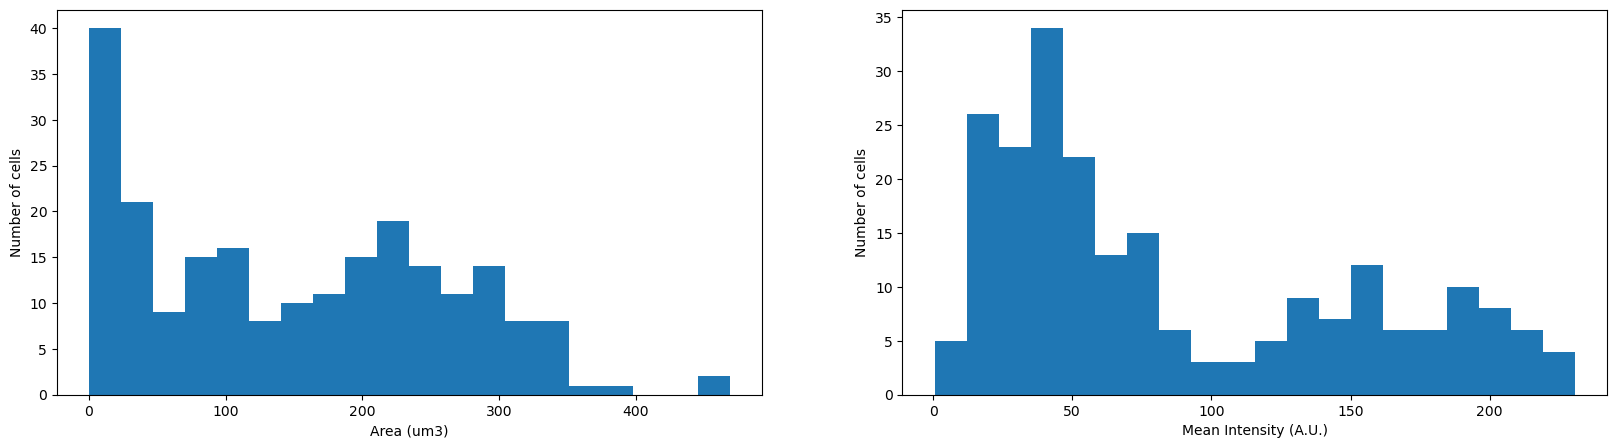

In [14]:
import matplotlib.pyplot as plt

data = pd.read_csv(r"F:\CI2A\Image Analysis\Aixa\Pilar\tables\Reunion Edwin 160223.lif - M155 40x s1 Hopx Sox2_intensity.csv")
mean_vector = data['mean_intensity']
vol_vector = data['area']

fig, axes = plt.subplots(1, 2, figsize=(20,5))
ax = axes.ravel()

ax[0].hist(vol_vector, bins=20)
ax[0].set_ylabel('Number of cells')
ax[0].set_xlabel('Area (um3)')

ax[1].hist(mean_vector, bins=20)
ax[1].set_ylabel('Number of cells')
ax[1].set_xlabel('Mean Intensity (A.U.)')

En este caso se puede observar que existen dos poblaciones de células basadas en la intensidad que se pueden separar a partir de 100 unidades, 